Testing standard keras transformers

Following https://keras.io/examples/structured_data/tabtransformer/

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from functools import partial
import matplotlib.pyplot as plt
from pathlib import Path
from aiproteomics.modelgen.prosit1.losses import masked_spectral_distance

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

2024-10-29 15:00:54.461813: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-29 15:00:54.495941: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 15:00:54.495969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 15:00:54.496785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 15:00:54.501643: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-29 15:00:54.502135: I tensorflow/core/platform/cpu_feature_guard.cc:1

Number of replicas: 1


In [17]:
AUTOTUNE = tf.data.AUTOTUNE
DATAPATH = Path("./data")
SAMPLE_FILE = DATAPATH/"randomized-0.tfrecord"
BATCH_SIZE = 64
VOCABULARY_SIZE = 30
SEQUENCE_LENGTH = 50
OUTPUT_SHAPE = 392

In [18]:
TRAINING_FILENAMES = VALID_FILENAMES = TEST_FILENAMES = [SAMPLE_FILE.resolve()]

print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

Train TFRecord Files: 1
Validation TFRecord Files: 1
Test TFRecord Files: 1


In [19]:
def read_tfrecord(example, labeled):
    print(f"This is what an example looks like: {example}")
        
    # Record spec
    if labeled:
        tfrecord_format = (
            {
                "charge": tf.io.FixedLenFeature([1], tf.int64),
                "msms": tf.io.FixedLenFeature([OUTPUT_SHAPE], tf.float32),
                "pep": tf.io.FixedLenFeature([SEQUENCE_LENGTH], tf.int64)
            }
        )
    else:
        tfrecord_format = (
            {
                "charge": tf.io.FixedLenFeature([1], tf.int64),
                "pep": tf.io.FixedLenFeature([SEQUENCE_LENGTH], tf.int64)
            }
        )
        
    # Parse data according to spec
    example = tf.io.parse_single_example(example, tfrecord_format)
    
    print(f"Parsed example: {example}")
    
    features = { "charge": tf.cast(example["charge"], tf.float32),
                "pep": tf.cast(example["pep"], tf.int32)}
    
    if labeled:
        label = tf.cast(example["msms"], tf.float32, name="msms")
        
        return features, label
    
    return features   
    

In [20]:
def load_dataset(filenames, labeled):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    
    return dataset


In [21]:
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [22]:
train_dataset = get_dataset(TRAINING_FILENAMES)
valid_dataset = get_dataset(VALID_FILENAMES)
test_dataset = get_dataset(TEST_FILENAMES)

train_dataset

This is what an example looks like: Tensor("args_0:0", shape=(), dtype=string)
Parsed example: {'charge': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(1,) dtype=int64>, 'msms': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=(392,) dtype=float32>, 'pep': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=(50,) dtype=int64>}
This is what an example looks like: Tensor("args_0:0", shape=(), dtype=string)
Parsed example: {'charge': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(1,) dtype=int64>, 'msms': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=(392,) dtype=float32>, 'pep': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=(50,) dtype=int64>}
This is what an example looks like: Tensor("args_0:0", shape=(), dtype=string)
Parsed example: {'charge': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(1,) dtype=int64>, 'msms': <tf.Tensor 'ParseSingleEx

<_BatchDataset element_spec=({'charge': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'pep': TensorSpec(shape=(None, 50), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 392), dtype=tf.float32, name=None))>

In [23]:
train_dataset.element_spec

({'charge': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None),
  'pep': TensorSpec(shape=(None, 50), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None, 392), dtype=tf.float32, name=None))

In [24]:
NUMERICAL_FEATURES = ["charge"]
CATEGORICAL_FEATURES = {"pep": list(range(VOCABULARY_SIZE))}
TARGET_FEATURE_NAME = "msms"
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES.keys())

In [25]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

In [26]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=masked_spectral_distance,
        metrics=[masked_spectral_distance],
    )

    train_dataset = get_dataset(train_data_file)
    validation_dataset = get_dataset(train_data_file)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

In [27]:
def create_model_inputs():
    # Inputs
    charge_input = layers.Input(
                name="charge", dtype="float32", batch_input_shape=(None, 1)
            )
    peptides = layers.Input(
                name="pep", dtype="int32", batch_input_shape=(None, SEQUENCE_LENGTH)
            )
    return {"charge": charge_input, "pep": peptides}

def encode_inputs(inputs, embedding_dims, vocabulary_size=VOCABULARY_SIZE):
    # Encoding
    embedding = layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dims)
    
    pep_embedding = embedding(inputs["pep"])
    
    # We are going to treat charge as a single float (maybe one hot encoded is better?)
    # We need the dimensions of charge to match the pep embedding
    
    
    charge_feature = tf.expand_dims(inputs["charge"], -1)
    
    print(f"Charge input: {inputs['charge']}")
    print(f"Charge expanded: {charge_feature}")
    
    
    charge_feature = tf.repeat(charge_feature, EMBEDDING_DIMS, axis=2)
    print(f"Charge repeated: {charge_feature}")
    
    return charge_feature, pep_embedding


def create_mlp(hidden_units,
                activation,
                normalization_layer,
                dropout_rate,
                name=None):
    mlp_layers = []
    
    for units in hidden_units:
        mlp_layers.append(normalization_layer())
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))
    
    mlp = keras.Sequential(mlp_layers, name=name)
    
    return mlp


Charge input: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='charge'), name='charge', description="created by layer 'charge'")
Charge expanded: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), name='tf.expand_dims_4/ExpandDims:0', description="created by layer 'tf.expand_dims_4'")
Charge repeated: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 16), dtype=tf.float32, name=None), name='tf.repeat_4/Repeat/Reshape_1:0', description="created by layer 'tf.repeat_4'")
Total model weights: 16086584


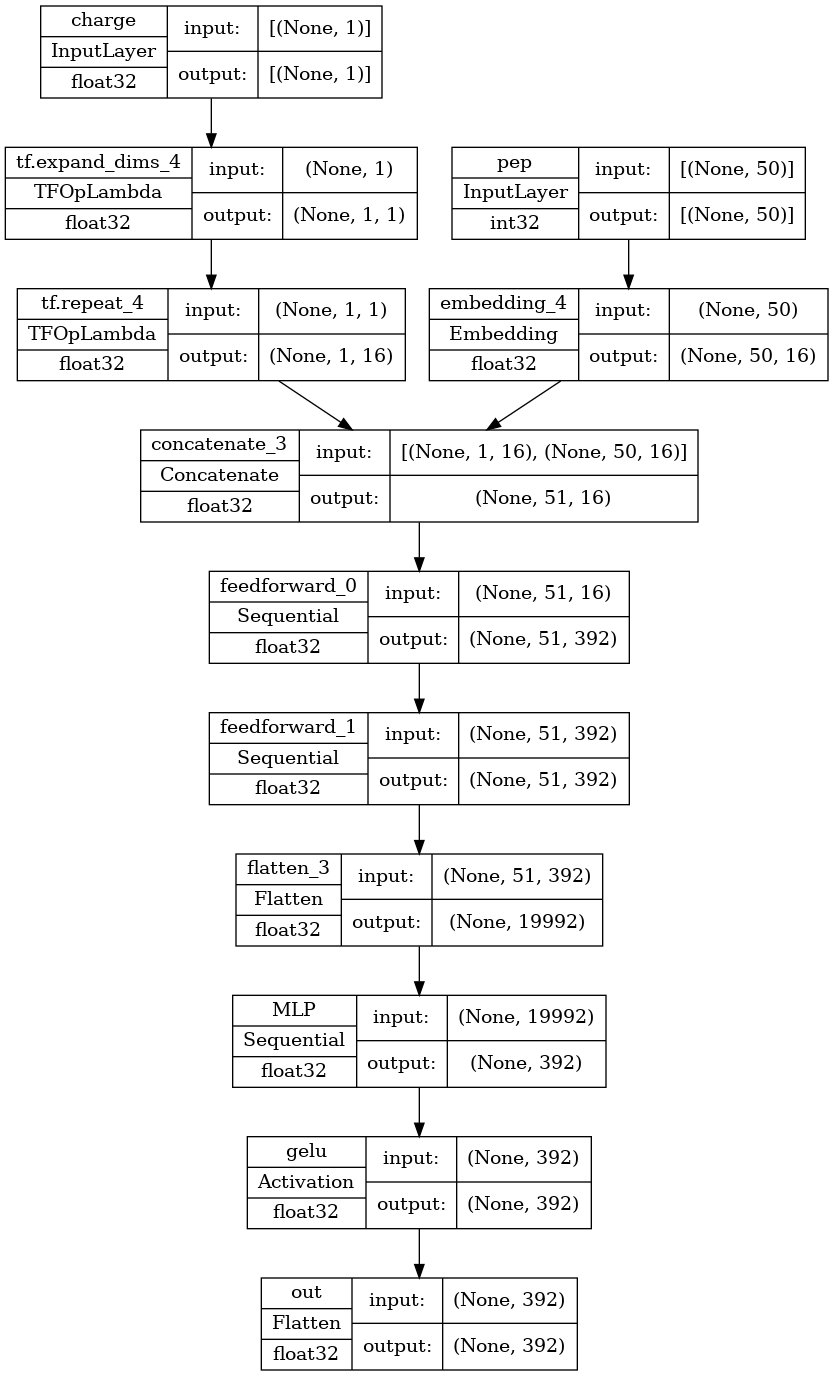

In [31]:
# Baseline model without transformer

def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    charge_feature, encoded_pep = encode_inputs(
        inputs, embedding_dims
    )

    features = layers.concatenate([charge_feature, encoded_pep], axis=1)
    
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1], OUTPUT_SHAPE]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization,
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    
    # Flatten everything
    features = layers.Flatten()(features)
    
    # Create final MLP.
    mlp = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)
    
    activation = layers.Activation(tf.keras.activations.gelu, name='gelu', trainable=True)(mlp)

    output_layer = layers.Flatten(
        name='out', data_format='channels_last', trainable=True)(activation)
    
    
    model = keras.Model(inputs=inputs, outputs=output_layer)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="TB", show_dtype=True)

In [32]:
run_experiment(baseline_model,TRAINING_FILENAMES, TEST_FILENAMES, NUM_EPOCHS, LEARNING_RATE, WEIGHT_DECAY, BATCH_SIZE)

This is what an example looks like: Tensor("args_0:0", shape=(), dtype=string)
Parsed example: {'charge': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(1,) dtype=int64>, 'msms': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=(392,) dtype=float32>, 'pep': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=(50,) dtype=int64>}
This is what an example looks like: Tensor("args_0:0", shape=(), dtype=string)
Parsed example: {'charge': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:0' shape=(1,) dtype=int64>, 'msms': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:1' shape=(392,) dtype=float32>, 'pep': <tf.Tensor 'ParseSingleExample/ParseExample/ParseExampleV2:2' shape=(50,) dtype=int64>}
Start training the model...
Epoch 1/15
    148/Unknown - 81s 531ms/step - loss: 0.5591 - masked_spectral_distance: 0.5591

KeyboardInterrupt: 

In [15]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):
    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = ops.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = ops.arange(start=0, stop=num_columns, step=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=partial(
                layers.LayerNormalization, epsilon=1e-6
            ),  # using partial to provide keyword arguments before initialization
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization,
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

Charge input: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name='charge'), name='charge', description="created by layer 'charge'")
Charge expanded: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None), name='tf.expand_dims_1/ExpandDims:0', description="created by layer 'tf.expand_dims_1'")
Charge repeated: KerasTensor(type_spec=TensorSpec(shape=(None, 1, 16), dtype=tf.float32, name=None), name='tf.repeat_1/Repeat/Reshape_1:0', description="created by layer 'tf.repeat_1'")


NameError: name 'ops' is not defined

In [ ]:
tfrecord_format = (
    {
        "charge": tf.io.FixedLenFeature([1], tf.int64),
        "msms": tf.io.FixedLenFeature([OUTPUT_SHAPE], tf.float32),
        "pep": tf.io.FixedLenFeature([50], tf.int64)
    }
)

raw_dataset = tf.data.TFRecordDataset(SAMPLE_FILE)
for raw_record in raw_dataset.take(1):
    example = tf.io.parse_single_example(raw_record, tfrecord_format)
    print(example)

In [ ]:


raw_dataset = tf.data.TFRecordDataset(SAMPLE_FILE)
for raw_record in raw_dataset.take(1):
    for sequence_length in range(400):
        #print(f"Trying {sequence_length}")
              
        tfrecord_format = (
            {
                "charge": tf.io.FixedLenFeature([1], tf.int64),
                "msms": tf.io.FixedLenFeature([OUTPUT_SHAPE], tf.float32),
                "pep": tf.io.FixedLenFeature([sequence_length], tf.int64)
            }
        )
        try:
            example = tf.io.parse_single_example(raw_record, tfrecord_format)
        except Exception as e:
            continue
        
        print(f"Sequence length is: {sequence_length}")
        break



# for raw_record in raw_dataset.take(1):
#     example = tf.io.parse_single_example(raw_record, tfrecord_format)
#     print(example)

In [ ]:
print(SAMPLE_FILE)
raw_dataset = tf.data.TFRecordDataset(SAMPLE_FILE)
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    
    print(example)

In [ ]:
InvalidArgumentError